# Test for the CNN Model

This notebook will be used to create and train a dummy version of the model that will be used for classifying the transit light curves.

In [20]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn

In [21]:
# Check whether GPU is available and choose a device to run the model on
gpu_available = torch.cuda.is_available()
device_name = "cuda" if gpu_available else "cpu"
device = torch.device(device_name)

print(f"Using {device_name}")

Using cuda


In [22]:
# Create dummy tensors for input

N = 5000   # Number of samples per type of input
L = 1000  # Length of input array

f1 = -5  # Bias of sine wave for the type 1 inputs
f2 = 5   # Bias of sine wave for the type 2 inputs

def normal(avg, std, dimensions):
    """Torch tensor of samples from a normal distribution, with given shape."""
    return torch.from_numpy(std * np.random.randn(*dimensions) + avg)

def uniform(mini, maxi, dimensions):
    """Torch tensor of samples from an uniform distribution between two numbers, with given shape."""
    return torch.from_numpy(np.random.random(dimensions)*(maxi-mini) - mini)

def create_sine_tensor(b, N, L):
    """Creates a series of sine wave vectors, with given bias and random phase, amplitude and frequency."""
    tensor = (normal(1., 0.1, [N, 1, 1]) * 
              torch.sin(normal(0, 10, [N, 1, 1]) * torch.arange(L).view(1, 1, L) + uniform(0, 2*np.pi, [N, 1, 1])) + 
              b + normal(0, 0., [N, 1, L]))
    return tensor

# Labels will be a categorical variable directly
type_1, label_1 = create_sine_tensor(f1, N, L), torch.zeros(N)
type_2, label_2 = create_sine_tensor(f2, N, L), torch.ones(N)

In [23]:
# Concatenate tensors from both types and store them in GPU if available
X, y = [torch.cat((type_1, type_2)).to(device, dtype=torch.float), 
         torch.cat((label_1, label_2)).to(device, dtype=torch.long)]

# Create an iterable dataset from the input and label tensors
dataset = TensorDataset(X, y)

In [24]:
# Perform the train/test/validation split
train_size = int(0.7 * len(y))
test_size  = int(0.2 * len(y))
valid_size = len(y) - train_size - test_size
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size, valid_size])

In [25]:
# Choose a batch size and create a data loader from the dataset

bs = 100  # Batch size
train_dl = DataLoader(train_dataset, batch_size=bs, shuffle=True)  # Needs shuffling to prevent correlation between batches
test_dl  = DataLoader(test_dataset,  batch_size=bs * 2)  # Test can use higher batch size because it needs less memory
valid_dl = DataLoader(valid_dataset, batch_size=bs * 2)  # Validation can use higher batch size because it needs less memory

In [26]:
X[0].size()

torch.Size([1, 1000])

In [27]:
class Test_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(8, 8, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(8, 4, kernel_size=3, stride=1, padding=1)
        self.fc1   = nn.Linear(1000, 50)
        self.fc2   = nn.Linear(50, 2)
        
    def forward(self, xb):  # xb is of size (1, 1000)
        
        # Convolutions and pooling
        xb = F.relu(self.conv1(xb))  # Size (8, 1000)
        xb = F.relu(self.conv2(xb))  # Size (8, 1000)
        xb = F.relu(self.conv3(xb))  # Size (4, 1000)
        xb = F.avg_pool1d(xb, 4)     # Size (4, 250)
        
        # Reshape to input the linear layer
        xb = xb.view(-1, 1000)  # -1 infers the necessary dimesion from the rest
        
        # Apply fully connected layers
        xb = F.relu(self.fc1(xb))    # Size (1, 50)
        xb = self.fc2(xb)            # Size (1, 2)
        
        return xb

In [28]:
def get_model():
    model = Test_CNN()
    return model, optim.SGD(model.parameters(), lr=lr)

In [29]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    # If an optimizer is used, then run as if trianing
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

In [30]:
def fit(epochs, model, loss_func, opt, train_dl, test_dl, verbose=True):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in test_dl]
                )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)  # Average the individual losses in the batch

        if verbose:
            print(f"Epoch: {epoch}; Validation loss: {val_loss}")

In [31]:
learning_rate = 2.
momentum      = 0.5
epochs        = 20

loss_func = F.cross_entropy
model = Test_CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [32]:
fit(epochs, model, loss_func, optimizer, train_dl, test_dl)

Epoch: 0; Validation loss: 0.7384360551834106
Epoch: 1; Validation loss: 0.6967483282089233
Epoch: 2; Validation loss: 0.6932131052017212
Epoch: 3; Validation loss: 0.6997573852539063
Epoch: 4; Validation loss: 0.6989070534706116
Epoch: 5; Validation loss: 0.7006918251514435
Epoch: 6; Validation loss: 0.7120021522045136
Epoch: 7; Validation loss: 0.7084070861339569
Epoch: 8; Validation loss: 0.6955600440502167
Epoch: 9; Validation loss: 0.6964947640895843
Epoch: 10; Validation loss: 0.6964199125766755
Epoch: 11; Validation loss: 0.6936882913112641
Epoch: 12; Validation loss: 0.6928821682929993
Epoch: 13; Validation loss: 0.69563227891922
Epoch: 14; Validation loss: 0.7029002964496612
Epoch: 15; Validation loss: 0.7015677750110626
Epoch: 16; Validation loss: 0.6991791367530823
Epoch: 17; Validation loss: 0.6929540514945984
Epoch: 18; Validation loss: 0.6928958833217621
Epoch: 19; Validation loss: 0.6935159623622894


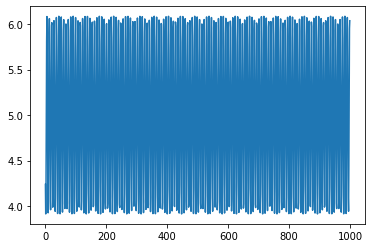

In [33]:
plt.plot(valid_dataset[5][0].cpu().numpy().flatten())

In [34]:
valid_dataset[5][1]

tensor(1, device='cuda:0')

In [35]:
F.cross_entropy(model(valid_dataset[5:6][0]), valid_dataset[5:6][1])

tensor(0.7552, device='cuda:0', grad_fn=<NllLossBackward>)

In [36]:
F.softmax(model(valid_dataset[5:6][0]), dim=1)

tensor([[0.5301, 0.4699]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [37]:
valid_dataset[5:6][0].size()

torch.Size([1, 1, 1000])